In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
import cv2
import os

print(torch.cuda.is_available(),torch.cuda.is_initialized())
torch.manual_seed(42)
np.random.seed(42)

True False


In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose,Normalize,ToTensor,Resize,CenterCrop
from torchvision.utils import make_grid
batch_size = 128

images = ImageFolder('./img_align_celeba',transform=Compose([Resize((64,64)),ToTensor(),Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])]))
train_dl = DataLoader(images,shuffle=True,num_workers=4,pin_memory=True,batch_size = 128)

print(len(train_dl))

1583


In [3]:
for i in train_dl:
    #print(len(i))
    print(i[0].shape)
    #print(i[0][0])
    print(i[1].shape)
    #print(i[1])
    break

torch.Size([128, 3, 64, 64])
torch.Size([128])


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(nn.Conv2d(in_channels=3,out_channels = 64,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=64),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(in_channels=64,out_channels = 128,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=128),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(in_channels=128,out_channels = 256,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=256),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(in_channels=256,out_channels = 512,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=512),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0),
                                  nn.Tanh())
    
    def forward(self,x):
        x = x.cuda()
        x = self.model(x)
        return x

In [5]:
class Generator(nn.Module):
    def __init__(self,z_size = 100):
        super(Generator,self).__init__()
        self.z_size = z_size
        
        self.model = nn.Sequential(nn.ConvTranspose2d(in_channels=100,out_channels = 1024,kernel_size=4,stride=1,padding=0),
                                  nn.BatchNorm2d(num_features=1024),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.ConvTranspose2d(in_channels=1024,out_channels = 512,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=512),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.ConvTranspose2d(in_channels=512,out_channels = 256,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=256),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.ConvTranspose2d(in_channels=256,out_channels = 128,kernel_size=4,stride=2,padding=1),
                                  nn.BatchNorm2d(num_features=128),
                                  nn.LeakyReLU(0.2,inplace=True),
                                  nn.ConvTranspose2d(in_channels=128,out_channels = 3,kernel_size=4,stride=2,padding=1),
                                  nn.Tanh())
        
        
    def forward(self,x):
        #x = x.view(-1,128,1,1)
        x = x.cuda()
        x = self.model(x)
        return x

In [6]:
class Gan():
    def __init__(self,z_size = 100):
        beta1 = 0.6
        beta2 = 0.999
        self.d_model = Discriminator().cuda()
        self.g_model = Generator().cuda()
        
        self.d_optim = torch.optim.Adam(self.d_model.parameters(),lr=1e-5,betas=(beta1,beta2))
        self.g_optim = torch.optim.Adam(self.g_model.parameters(),lr=1e-5,betas=(beta1,beta2))
        
        self.z_size = z_size
        self.fixed_noise = torch.randn(64,z_size,1,1)
        
    def clamp_weights(self,model):
        with torch.no_grad():
            for i in model.parameters():
                i.data.clamp_(-0.01,0.01)
            
    def d_loss(self,real,fake):
        return -torch.mean(self.d_model(real)) + torch.mean(self.d_model(fake))
    
    def g_loss(self,fake):
        return -torch.mean(self.d_model(fake))
        
    def train(self,dl,epochs=10,n_critic=3):
        if 'generated' not in os.listdir('.'):
            os.mkdir('generated')
        for epoch in range(epochs):
            for i,batch in enumerate(dl):
                self.d_optim.zero_grad()
                
                real_images = batch[0].cuda()
                batch_size = real_images.shape[0]
                #real_labels = torch.ones((batch_size,1)).cuda()
                #fake_labels = torch.zeros((batch_size,1)).cuda()
                z = torch.randn((real_images.shape[0],self.z_size,1,1)).cuda()
                fake_images = self.g_model(z)
                
                
                total_loss = self.d_loss(real_images,fake_images)
                total_loss.backward()
                self.d_optim.step()
                
                self.clamp_weights(self.d_model)
                
                if i%n_critic == 0:
                    self.g_optim.zero_grad()
                    #z = torch.randn((real_images.shape[0],self.z_size,1,1)).cuda()
                    gen_images = self.g_model(z)
                    gen_loss = self.g_loss(gen_images)
                    gen_loss.backward()
                    self.g_optim.step()
                
                if i%(n_critic*10) == 0:
                    with torch.no_grad():
                        print(f'for Epoch:{epoch} and batch:{i} - ')
                        print(f'Discriminator loss: {total_loss.item()}')
                        print(f'Generator loss: {gen_loss.item()}')
                        print('---------------------------------------------------')
                        
                        gen_images = self.g_model(self.fixed_noise).detach().cpu()
                        gen_images = ((gen_images * 127.5) + 127.5).type(torch.uint8)
                        gen_images = make_grid(gen_images, nrow=8).permute(1,2,0).numpy()
                        cv2.imwrite(f'./generated/{epoch}-{i}.jpg',cv2.cvtColor(gen_images, cv2.COLOR_RGB2BGR))
                    

In [7]:
model = Gan()
model.train(train_dl,epochs=10,n_critic=3)

for Epoch:0 and batch:0 - 
Discriminator loss: 0.05568655580282211
Generator loss: -0.0009583471110090613
---------------------------------------------------
for Epoch:0 and batch:30 - 
Discriminator loss: 0.0032943878322839737
Generator loss: -0.006359432823956013
---------------------------------------------------
for Epoch:0 and batch:60 - 
Discriminator loss: 0.0034065209329128265
Generator loss: -0.007663413416594267
---------------------------------------------------
for Epoch:0 and batch:90 - 
Discriminator loss: 0.0017087422311306
Generator loss: -0.007046914659440517
---------------------------------------------------
for Epoch:0 and batch:120 - 
Discriminator loss: -0.00012761401012539864
Generator loss: -0.006391470320522785
---------------------------------------------------
for Epoch:0 and batch:150 - 
Discriminator loss: -0.002095910720527172
Generator loss: -0.006281466688960791
---------------------------------------------------
for Epoch:0 and batch:180 - 
Discriminato

for Epoch:0 and batch:1560 - 
Discriminator loss: -1.0557003021240234
Generator loss: 0.5260059833526611
---------------------------------------------------
for Epoch:1 and batch:0 - 
Discriminator loss: -1.052965760231018
Generator loss: 0.5275084972381592
---------------------------------------------------
for Epoch:1 and batch:30 - 
Discriminator loss: -1.0584959983825684
Generator loss: 0.5318902134895325
---------------------------------------------------
for Epoch:1 and batch:60 - 
Discriminator loss: -1.0763622522354126
Generator loss: 0.5344712138175964
---------------------------------------------------
for Epoch:1 and batch:90 - 
Discriminator loss: -1.0776400566101074
Generator loss: 0.5376039743423462
---------------------------------------------------
for Epoch:1 and batch:120 - 
Discriminator loss: -1.0830497741699219
Generator loss: 0.539535403251648
---------------------------------------------------
for Epoch:1 and batch:150 - 
Discriminator loss: -1.094228744506836
Ge

for Epoch:1 and batch:1560 - 
Discriminator loss: -1.173382043838501
Generator loss: 0.5840731859207153
---------------------------------------------------
for Epoch:2 and batch:0 - 
Discriminator loss: -1.186544418334961
Generator loss: 0.590334415435791
---------------------------------------------------
for Epoch:2 and batch:30 - 
Discriminator loss: -1.1953566074371338
Generator loss: 0.594100832939148
---------------------------------------------------
for Epoch:2 and batch:60 - 
Discriminator loss: -1.2054088115692139
Generator loss: 0.59724360704422
---------------------------------------------------
for Epoch:2 and batch:90 - 
Discriminator loss: -1.2046229839324951
Generator loss: 0.5985527634620667
---------------------------------------------------
for Epoch:2 and batch:120 - 
Discriminator loss: -1.208150863647461
Generator loss: 0.5987579822540283
---------------------------------------------------
for Epoch:2 and batch:150 - 
Discriminator loss: -1.2048602104187012
Genera

for Epoch:2 and batch:1560 - 
Discriminator loss: -0.7315430641174316
Generator loss: 0.40456563234329224
---------------------------------------------------
for Epoch:3 and batch:0 - 
Discriminator loss: -0.7359224557876587
Generator loss: 0.36737629771232605
---------------------------------------------------
for Epoch:3 and batch:30 - 
Discriminator loss: -0.7391791343688965
Generator loss: 0.3945956230163574
---------------------------------------------------
for Epoch:3 and batch:60 - 
Discriminator loss: -0.7191152572631836
Generator loss: 0.3772692084312439
---------------------------------------------------
for Epoch:3 and batch:90 - 
Discriminator loss: -0.7955152988433838
Generator loss: 0.4186375141143799
---------------------------------------------------
for Epoch:3 and batch:120 - 
Discriminator loss: -0.7593284845352173
Generator loss: 0.3997507095336914
---------------------------------------------------
for Epoch:3 and batch:150 - 
Discriminator loss: -0.82338345050811

for Epoch:3 and batch:1560 - 
Discriminator loss: -0.793512225151062
Generator loss: 0.4341205954551697
---------------------------------------------------
for Epoch:4 and batch:0 - 
Discriminator loss: -0.7317181825637817
Generator loss: 0.40268799662590027
---------------------------------------------------
for Epoch:4 and batch:30 - 
Discriminator loss: -0.7844382524490356
Generator loss: 0.4227268397808075
---------------------------------------------------
for Epoch:4 and batch:60 - 
Discriminator loss: -0.7692793011665344
Generator loss: 0.39281925559043884
---------------------------------------------------
for Epoch:4 and batch:90 - 
Discriminator loss: -0.7964175939559937
Generator loss: 0.41111114621162415
---------------------------------------------------
for Epoch:4 and batch:120 - 
Discriminator loss: -0.7892613410949707
Generator loss: 0.41797178983688354
---------------------------------------------------
for Epoch:4 and batch:150 - 
Discriminator loss: -0.8371526002883

for Epoch:4 and batch:1560 - 
Discriminator loss: -0.7625113129615784
Generator loss: 0.40699297189712524
---------------------------------------------------
for Epoch:5 and batch:0 - 
Discriminator loss: -0.7862648367881775
Generator loss: 0.367847740650177
---------------------------------------------------
for Epoch:5 and batch:30 - 
Discriminator loss: -0.7970237731933594
Generator loss: 0.36687442660331726
---------------------------------------------------
for Epoch:5 and batch:60 - 
Discriminator loss: -0.7231227159500122
Generator loss: 0.351593017578125
---------------------------------------------------
for Epoch:5 and batch:90 - 
Discriminator loss: -0.7623960375785828
Generator loss: 0.3794792592525482
---------------------------------------------------
for Epoch:5 and batch:120 - 
Discriminator loss: -0.6595357656478882
Generator loss: 0.3189898133277893
---------------------------------------------------
for Epoch:5 and batch:150 - 
Discriminator loss: -0.7605079412460327

for Epoch:5 and batch:1560 - 
Discriminator loss: -0.7247240543365479
Generator loss: 0.36474937200546265
---------------------------------------------------
for Epoch:6 and batch:0 - 
Discriminator loss: -0.6835927963256836
Generator loss: 0.3301994800567627
---------------------------------------------------
for Epoch:6 and batch:30 - 
Discriminator loss: -0.8422906398773193
Generator loss: 0.4302300810813904
---------------------------------------------------
for Epoch:6 and batch:60 - 
Discriminator loss: -0.9041827917098999
Generator loss: 0.45955759286880493
---------------------------------------------------
for Epoch:6 and batch:90 - 
Discriminator loss: -0.8556232452392578
Generator loss: 0.4477996230125427
---------------------------------------------------
for Epoch:6 and batch:120 - 
Discriminator loss: -0.4772113859653473
Generator loss: 0.47082966566085815
---------------------------------------------------
for Epoch:6 and batch:150 - 
Discriminator loss: -0.7025599479675

for Epoch:6 and batch:1560 - 
Discriminator loss: -0.7665787935256958
Generator loss: 0.37824714183807373
---------------------------------------------------
for Epoch:7 and batch:0 - 
Discriminator loss: -0.7535701394081116
Generator loss: 0.3657550811767578
---------------------------------------------------
for Epoch:7 and batch:30 - 
Discriminator loss: -0.7566871643066406
Generator loss: 0.377771258354187
---------------------------------------------------
for Epoch:7 and batch:60 - 
Discriminator loss: -0.7353739738464355
Generator loss: 0.38926610350608826
---------------------------------------------------
for Epoch:7 and batch:90 - 
Discriminator loss: -0.7738479375839233
Generator loss: 0.4130729138851166
---------------------------------------------------
for Epoch:7 and batch:120 - 
Discriminator loss: -0.6918936967849731
Generator loss: 0.39578068256378174
---------------------------------------------------
for Epoch:7 and batch:150 - 
Discriminator loss: -0.68161273002624

for Epoch:7 and batch:1560 - 
Discriminator loss: -0.7577768564224243
Generator loss: 0.3549763858318329
---------------------------------------------------
for Epoch:8 and batch:0 - 
Discriminator loss: -0.8232703804969788
Generator loss: 0.4243021607398987
---------------------------------------------------
for Epoch:8 and batch:30 - 
Discriminator loss: -0.903069257736206
Generator loss: 0.44609493017196655
---------------------------------------------------
for Epoch:8 and batch:60 - 
Discriminator loss: -0.8853920698165894
Generator loss: 0.4498554766178131
---------------------------------------------------
for Epoch:8 and batch:90 - 
Discriminator loss: -0.9166965484619141
Generator loss: 0.4738274812698364
---------------------------------------------------
for Epoch:8 and batch:120 - 
Discriminator loss: -0.8691229224205017
Generator loss: 0.44100669026374817
---------------------------------------------------
for Epoch:8 and batch:150 - 
Discriminator loss: -0.619743466377258

for Epoch:8 and batch:1560 - 
Discriminator loss: -0.7465209364891052
Generator loss: 0.40152624249458313
---------------------------------------------------
for Epoch:9 and batch:0 - 
Discriminator loss: -0.7156620025634766
Generator loss: 0.18313023447990417
---------------------------------------------------
for Epoch:9 and batch:30 - 
Discriminator loss: -0.7143927812576294
Generator loss: 0.4244622588157654
---------------------------------------------------
for Epoch:9 and batch:60 - 
Discriminator loss: -0.7833192348480225
Generator loss: 0.4082064628601074
---------------------------------------------------
for Epoch:9 and batch:90 - 
Discriminator loss: -0.7252748012542725
Generator loss: 0.38822829723358154
---------------------------------------------------
for Epoch:9 and batch:120 - 
Discriminator loss: -0.7484450340270996
Generator loss: 0.3945361077785492
---------------------------------------------------
for Epoch:9 and batch:150 - 
Discriminator loss: -0.7807201743125

for Epoch:9 and batch:1560 - 
Discriminator loss: -0.7773423790931702
Generator loss: 0.3827756345272064
---------------------------------------------------


In [8]:
%matplotlib inline
def generate_images(model,samples=64):
    with torch.no_grad():
        z = torch.randn((samples,100,1,1)).cuda()
        gen_images = model(z).detach().cpu()
        gen_images = ((gen_images * 127.5) + 127.5).type(torch.uint8)
        gen_images = make_grid(gen_images, nrow=samples//int(np.sqrt(samples))).permute(1,2,0).numpy()
        plt.imshow(gen_images)

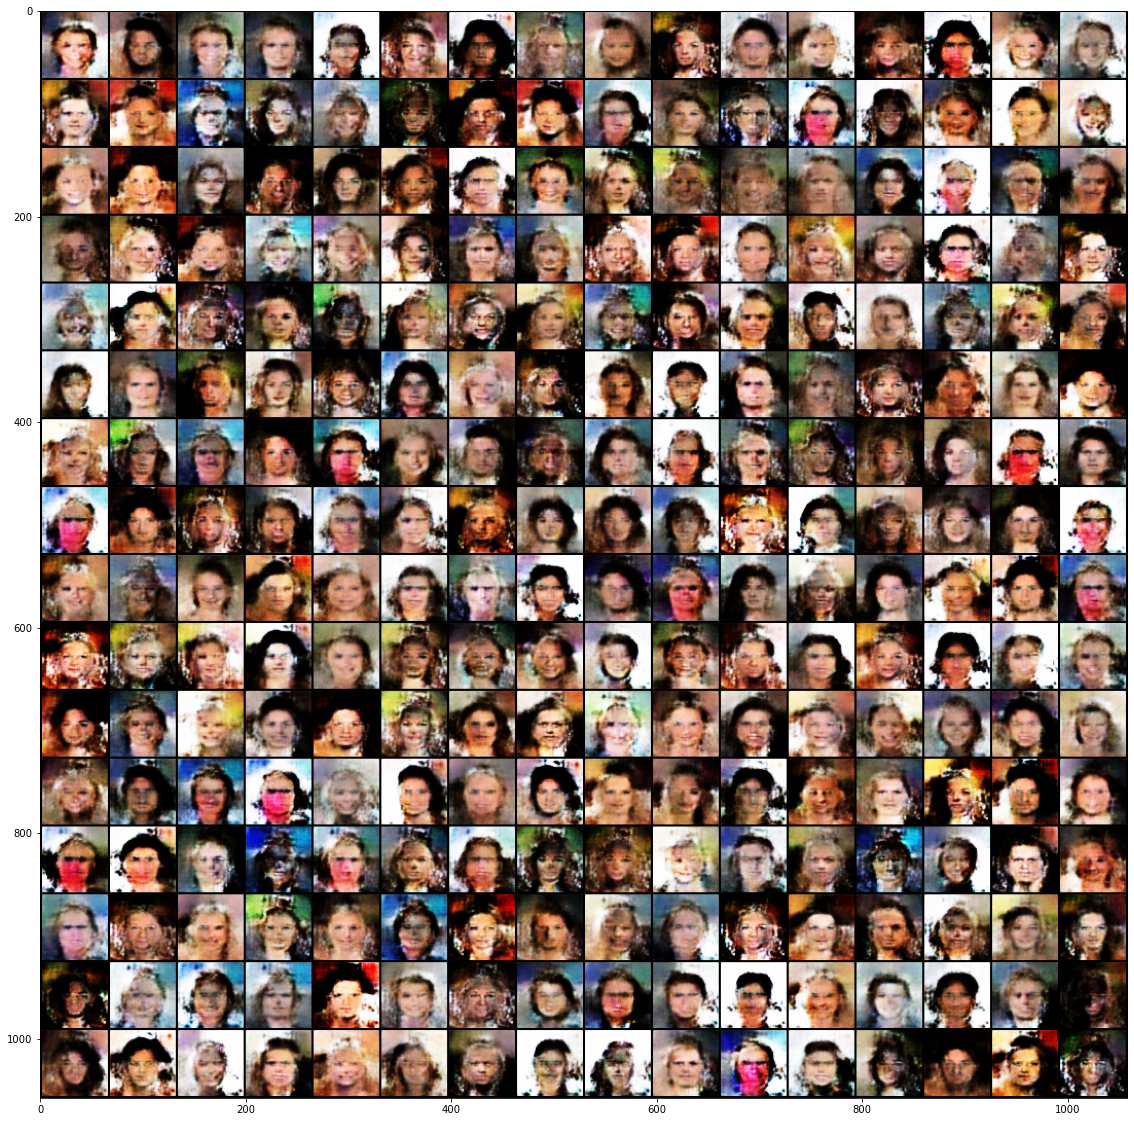

In [9]:
plt.figure(figsize=(20,20))
generate_images(model.g_model,samples=256)